In [10]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the solution space 
# where basalt > calcite based on different 
# CDR accounting choices
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "low"
idx_1 = "002"
tag_sil_1 = "basev1"

# FERT LEVEL 2
fertLevel_2 = "hi"
idx_2 = "002"
tag_sil_2 = "basev1"



In [11]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))

# Plot 1:
Three accounting panels, low and hi fert 

In [4]:
ds_anom2.cdr_calc

<xarray.DataArray 'cdr_calc' (cdr_calc: 5)> Size: 40B
array(['netR', 'netR_noNeg', 'simplesubtract', 'simplesubtract_noNeg',
       'conservative'], dtype=object)
Coordinates:
  * cdr_calc  (cdr_calc) object 40B 'netR' 'netR_noNeg' ... 'conservative'

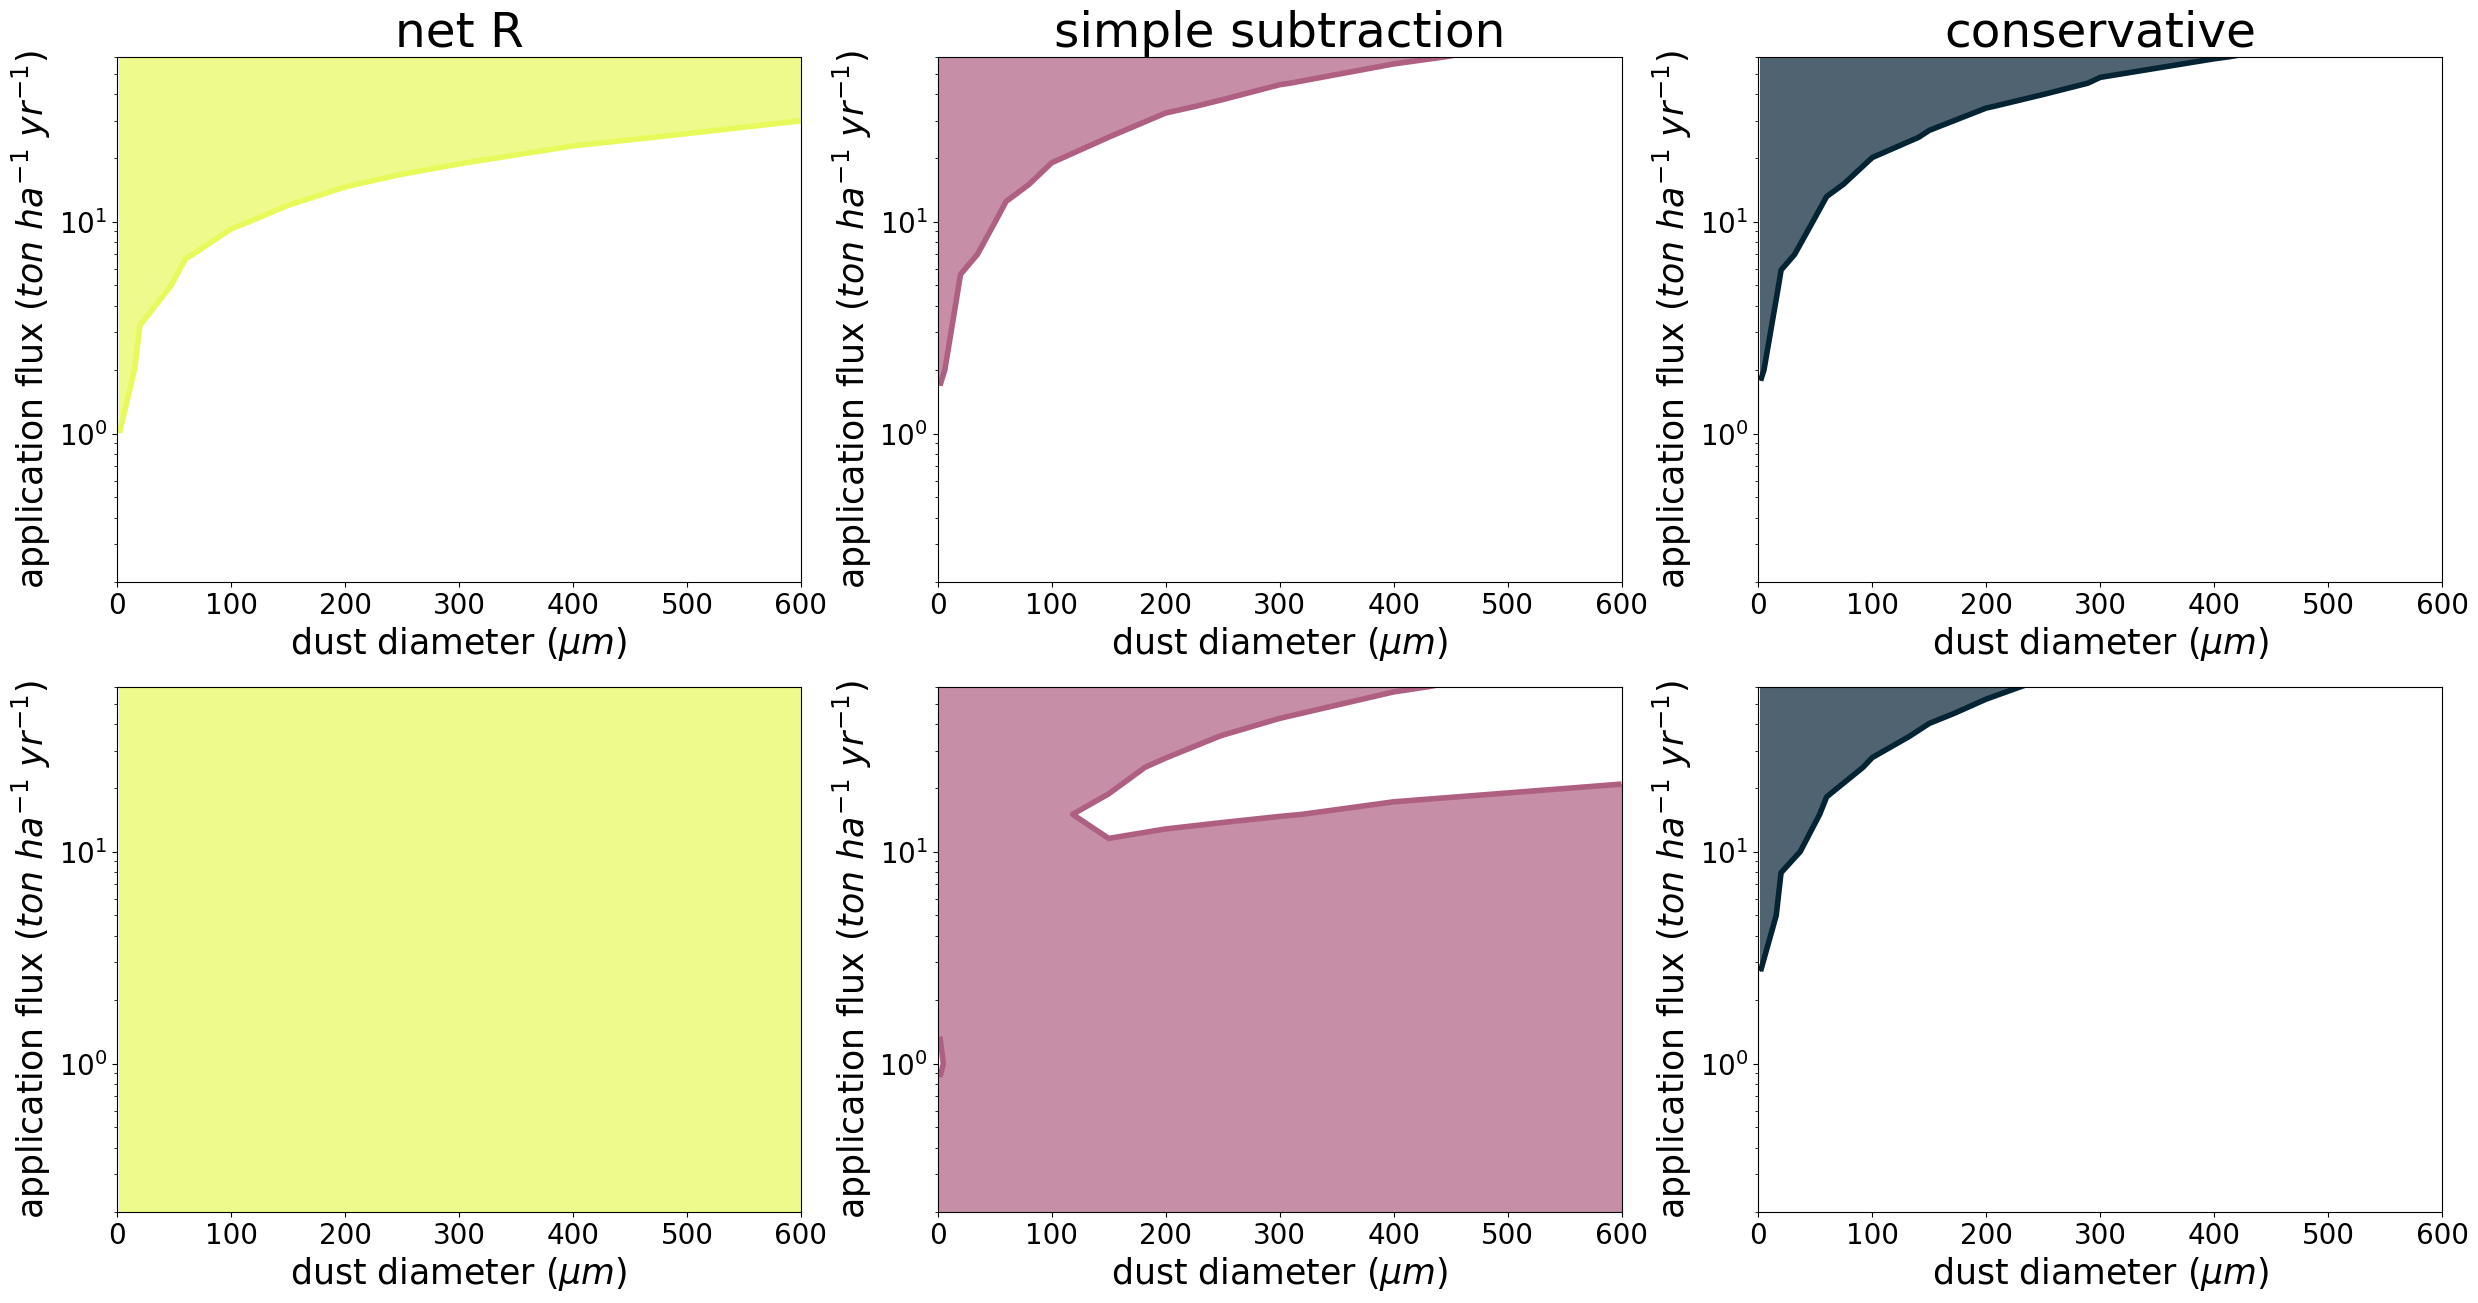

In [36]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif'
loss_percent = 12
logX = False
logY = True

# cdr_calc = {'net R': 'netR', 'no negative R': 'netR_noNeg', 'simple subtraction': 'simplesubtract', 'conservative': 'conservative'}
cdr_calc_ALL = {'net R': 'netR', 'simple subtraction': 'simplesubtract', 'positive simple subtraction': 'simplesubtract_noNeg', 'conservative': 'conservative'}
cdr_calc_PLOT_idx = [0, 1, 3]


# pull out the data we want
# [fert level 1]
ds1_c1 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc_ALL.values())[cdr_calc_PLOT_idx[0]]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c2 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc_ALL.values())[cdr_calc_PLOT_idx[1]]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds1_c3 = ds_anom1.sel(feedstock = feedstock, cdr_calc=list(cdr_calc_ALL.values())[cdr_calc_PLOT_idx[2]]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [fert level 2]
ds2_c1 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc_ALL.values())[cdr_calc_PLOT_idx[0]]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c2 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc_ALL.values())[cdr_calc_PLOT_idx[1]]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_c3 = ds_anom2.sel(feedstock = feedstock, cdr_calc=list(cdr_calc_ALL.values())[cdr_calc_PLOT_idx[2]]).sel(loss_percent=loss_percent, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
# [fert level 1]
ds1_c1 = ds1_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c2 = ds1_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds1_c3 = ds1_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# [fert level 2]
ds2_c1 = ds2_c1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c2 = ds2_c2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_c3 = ds2_c3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = [tuple(color) for color in cmo.thermal_r(np.linspace(0, 1, 3))]
# linewidths
lwds = 4
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 35    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1]
# ... c1
x1c1 = ds1_c1['dustrad'].values
y1c1 = ds1_c1['dustrate_ton_ha_yr'].values
# [fertlevel 2]
# ... c1
x2c1 = ds2_c1['dustrad'].values
y2c1 = ds2_c1['dustrate_ton_ha_yr'].values


# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=3, nrows=2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1])
plt.figure(figsize=(30,15))

# --- COLUMN 1 --------------------------
# [TOP]
ax = plt.subplot(spec[0])
contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0,ds1_c1.transpose().max()], colors=col[0:], alpha=0.7)
contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[0]])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[0]], fontsize=fs_title)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# [BOTTOM]
ax = plt.subplot(spec[3])
contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0,ds2_c1.transpose().max()], colors=col[0:], alpha=0.7)
contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c1.transpose(),levels=[0], colors=col, linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[0]])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")


# --- COLUMN 2 --------------------------
# [TOP]
ax = plt.subplot(spec[1])
contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c2.transpose(),levels=[0,ds1_c2.transpose().max()], colors=col[1:], alpha=0.7)
contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c2.transpose(),levels=[0], colors=col[1], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[1]])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[1]], fontsize=fs_title)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# [BOTTOM]
ax = plt.subplot(spec[4])
contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c2.transpose(),levels=[0,ds2_c2.transpose().max()], colors=col[1:], alpha=0.7)
contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c2.transpose(),levels=[0], colors=col[1], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[1]])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")


# --- COLUMN 3 --------------------------
# [TOP]
ax = plt.subplot(spec[2])
contourf1 = plt.contourf(x1c1*2, y1c1, ds1_c3.transpose(),levels=[0,ds1_c3.transpose().max()], colors=col[2:], alpha=0.7)
contour_line1 = plt.contour(x1c1*2, y1c1, ds1_c3.transpose(),levels=[0], colors=col[2], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[2]])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[2]], fontsize=fs_title)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# [BOTTOM]
ax = plt.subplot(spec[5])
contourf1 = plt.contourf(x2c1*2, y2c1, ds2_c3.transpose(),levels=[0,ds2_c3.transpose().max()], colors=col[2:], alpha=0.7)
contour_line1 = plt.contour(x2c1*2, y2c1, ds2_c3.transpose(),levels=[0], colors=col[2], linewidths=lwds)
legend_line1 = Line2D([0], [0], color=col[0], linewidth=lwds, label=list(cdr_calc_ALL.keys())[cdr_calc_PLOT_idx[2]])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")



plt.show()
plt.close();


In [37]:
# ---------
